In [7]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adadelta, Adam, Adamax, Adagrad, RMSprop, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Downloading the dataset
If you have not downloaded the dataset yet, run the following cell. If you have already done this, you can skip this step.

In [2]:
!mkdir ./data
!mkdir ./data2
!wget -O ./data/fer2013.csv https://www.dropbox.com/s/n8bninud94blch4/fer2013.csv

# source https://www.kaggle.com/davidvictor/face-classification/notebook

--2022-01-01 13:10:27--  https://www.dropbox.com/s/n8bninud94blch4/fer2013.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n8bninud94blch4/fer2013.csv [following]
--2022-01-01 13:10:27--  https://www.dropbox.com/s/raw/n8bninud94blch4/fer2013.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3fa51513f7609467d3d9f45331.dl.dropboxusercontent.com/cd/0/inline/Bc_uzLcVHdS6xVwSS7n0jl0bjmj4c41pEqDYPJrq-wbICjhCylS7z6xzbUXpv2oTc7yYN0_jgBxX-ZQZNvKXM2jETHbm9vyC3fbinV04Unc8GqlMuYdk4xNQSGvaOxmYGGhagn5fq238Wnxp9FmuICK2/file# [following]
--2022-01-01 13:10:27--  https://uc3fa51513f7609467d3d9f45331.dl.dropboxusercontent.com/cd/0/inline/Bc_uzLcVHdS6xVwSS7n0jl0bjmj4c41pEqDYPJrq-wbICjhCylS7z6xzbUXpv2oTc7yYN0_jgBxX-ZQZNvKXM2jETHbm9

In [3]:
fer_data = pd.read_csv("./data/fer2013.csv")

# dataset-format : x -> image matrix, y -> label
x_train = []
y_train = []
x_test = []
y_test = []
for index, row in fer_data.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        x_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        x_test.append(np.array(k))
        y_test.append(row['emotion'])

print(len(x_train))
print(len(x_test))

# source : https://www.analyticsvidhya.com/blog/2021/11/facial-emotion-detection-using-cnn/

28709
3589


In [4]:
# transform the List object to nparray

x_train = np.array(x_train, dtype='float64')
y_train = np.array(y_train, dtype='float64')
x_test = np.array(x_test, dtype='float64')
y_test = np.array(y_test, dtype='float64')

# Format the array to a 48*48 matrix
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)

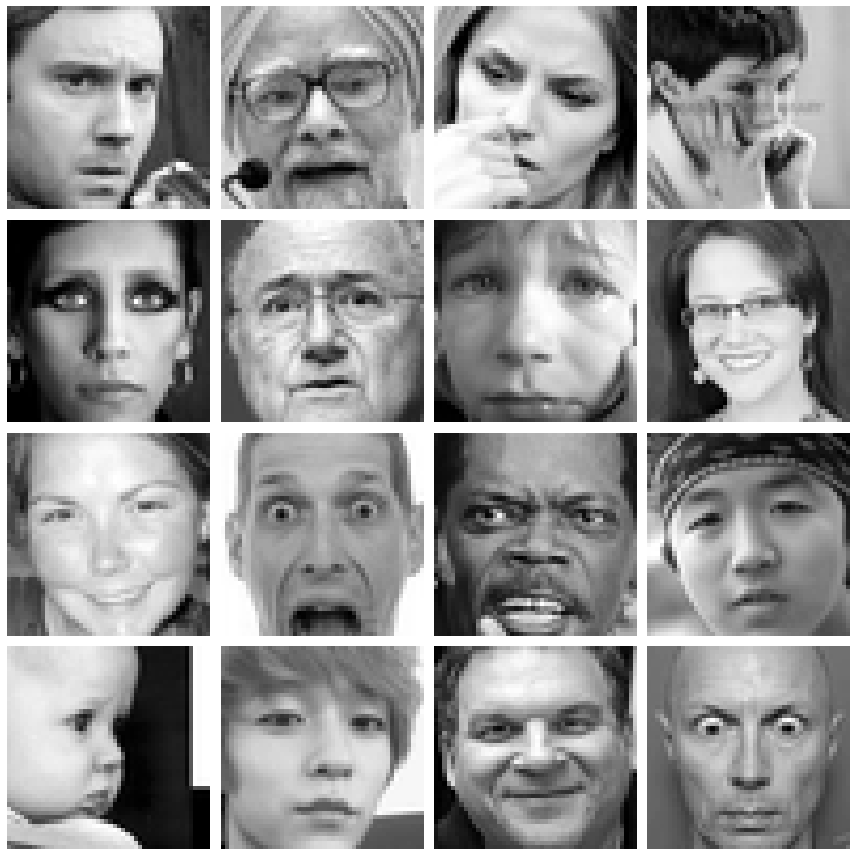

In [5]:
plt.style.use('ggplot')

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i].reshape((48, 48)), cmap="gray")
    plt.axis('off')
    plt.tight_layout()

# Building Facial Emotion Detection Model using CNN
Designing the CNN model for emotion detection.

We are creating blocks using Conv2D layer, Batch-Normalization, Max-Pooling2D, Dropout, Flatten, and then stacking them together and at the end-use Dense Layer for output.

In [ ]:
model = Sequential()
# Layer 1
model.add(Conv2D(32,(3,3),padding='same', input_shape=(48, 48, 1), activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #reduce the spatial dimensions of the output volume
model.add(Dropout(0.25))
# Layer 2
model.add(Conv2D(64,(3,3),padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Layer 3
model.add(Conv2D(128,(3,3),padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Layer 5
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Layer 6
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Layer 7
model.add(Dense(7, activation='softmax', kernel_initializer='he_uniform'))

summary = model.summary()

model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', # multi class classification problem
    metrics = ['accuracy'])

print(summary)


In [ ]:
model.save_weights("./data/weights.h5")

# Fitting tho model with training and testing data

In [ ]:
checkpoint = ModelCheckpoint('./data/checkpoint.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [earlystop,checkpoint,reduce_learning_rate]

In [ ]:
history = model.fit(x_train, y_train, batch_size=45, epochs=50, callbacks=callbacks_list, validation_split=0.1)

# Saving and evaluating the model

In [ ]:
model.save('./data/output')
model.load_weights('./data/checkpoint.h5')
eval = model.evaluate(x_test, y_test, verbose=1)
# TODO : summarize_diagnosis to pyplot as in : https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

INFO:tensorflow:Assets written to: ./data/output/assets
113/113 [==============================] - 1s 11ms/step - loss: 1.0432 - accuracy: 0.6135


# Plotting

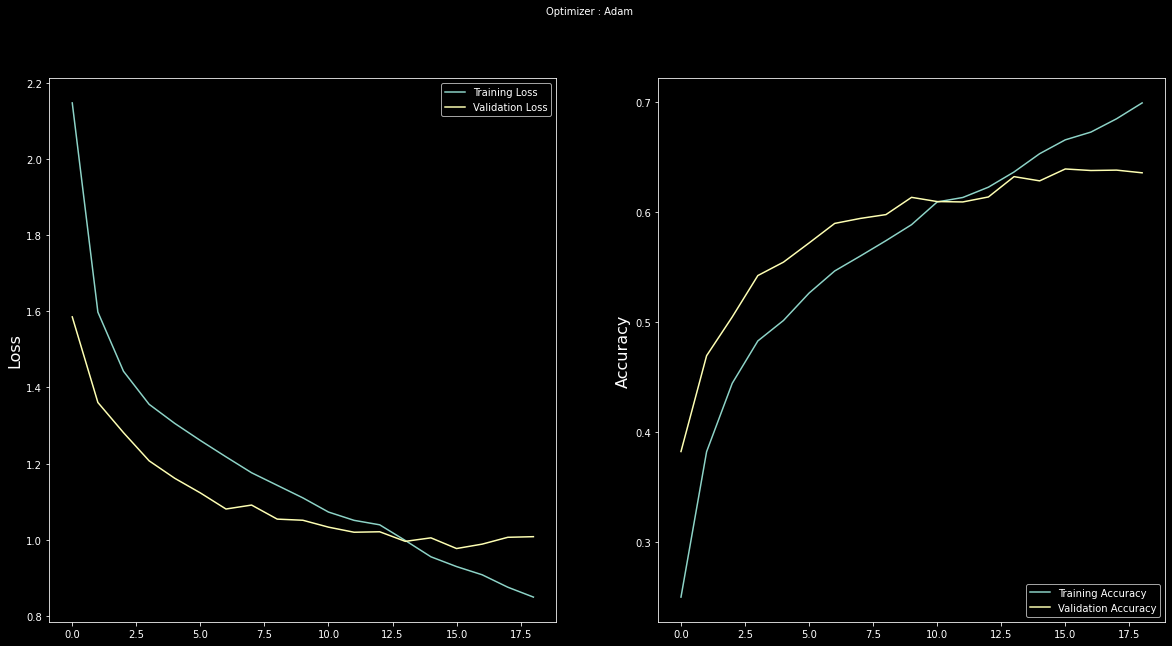

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Claudia (Schiffer)

In [17]:
class_amount = 7
Claudia = Sequential([
        # Convolution 1
        Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)),
        MaxPooling2D(pool_size=(5,5), strides=(2, 2)),
        # Convolution 2
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
        # Convolution 3
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        AveragePooling2D(pool_size=(3,3), strides=(2, 2)),

        Flatten(),
        # Fully connected
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(class_amount, activation='softmax')
    ])

summary = Claudia.summary()

Claudia.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', # multi class classification problem
    metrics = ['accuracy'])

Claudia.save_weights("./data2/weights.h5")

checkpoint2 = ModelCheckpoint('./data2/checkpoint.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)
earlystop2 = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_learning_rate2 = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list2 = [earlystop2,checkpoint2,reduce_learning_rate2]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 18, 18, 64)        36928     
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 average_pooling2d_4 (Averag  (None, 7, 7, 64)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_13 (Conv2D)          (None, 5, 5, 128)        

In [18]:
historia = Claudia.fit(x_train, y_train, batch_size=45, epochs=50, callbacks=callbacks_list2, validation_split=0.1)

Epoch 1/50
575/575 [==============================] - ETA: 0s - loss: 1.8346 - accuracy: 0.2484
Epoch 00001: val_accuracy improved from -inf to 0.25845, saving model to ./data2/checkpoint.h5
575/575 [==============================] - 17s 29ms/step - loss: 1.8346 - accuracy: 0.2484 - val_loss: 1.7632 - val_accuracy: 0.2584 - lr: 0.0010
Epoch 2/50
574/575 [============================>.] - ETA: 0s - loss: 1.6943 - accuracy: 0.3170
Epoch 00002: val_accuracy improved from 0.25845 to 0.36224, saving model to ./data2/checkpoint.h5
575/575 [==============================] - 16s 27ms/step - loss: 1.6943 - accuracy: 0.3170 - val_loss: 1.6136 - val_accuracy: 0.3622 - lr: 0.0010
Epoch 3/50
573/575 [============================>.] - ETA: 0s - loss: 1.5673 - accuracy: 0.3865
Epoch 00003: val_accuracy improved from 0.36224 to 0.41832, saving model to ./data2/checkpoint.h5
575/575 [==============================] - 16s 28ms/step - loss: 1.5676 - accuracy: 0.3862 - val_loss: 1.5172 - val_accuracy: 0.4

In [19]:
Claudia.save('./data2/output')
Claudia.save_weights("./data2/weights.h5")
Claudia.load_weights('./data2/checkpoint.h5')
eval2 = Claudia.evaluate(x_test, y_test, verbose=1)

INFO:tensorflow:Assets written to: ./data2/output/assets
113/113 [==============================] - 1s 9ms/step - loss: 1.3038 - accuracy: 0.5210


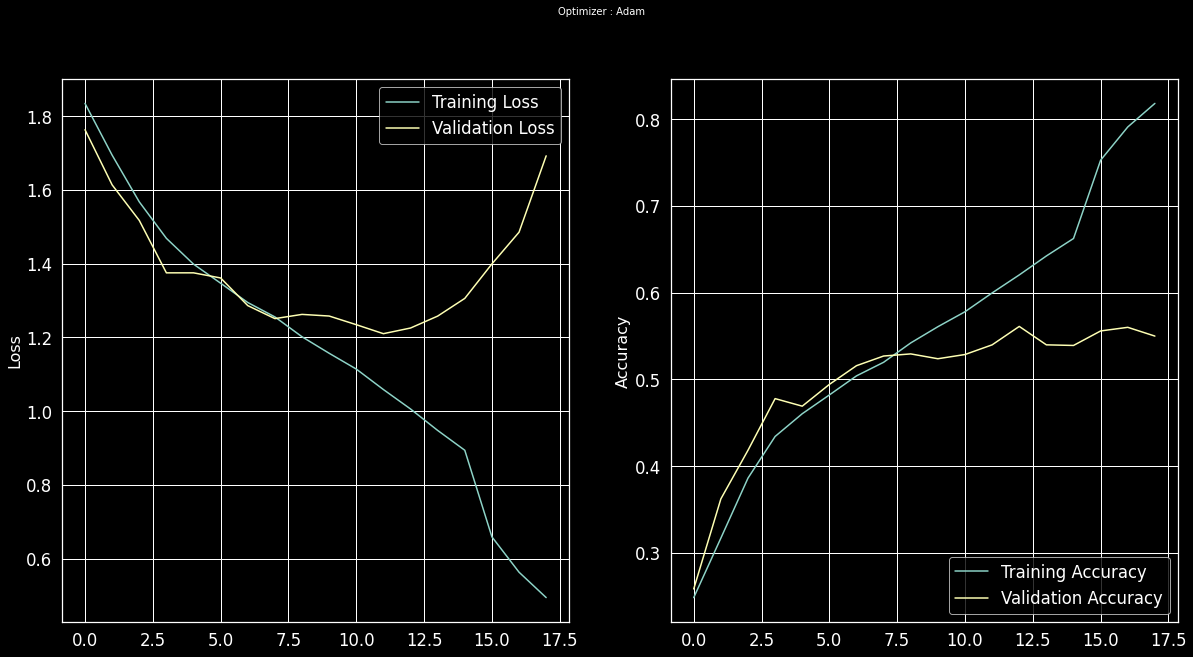

In [20]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(historia.history['loss'], label='Training Loss')
plt.plot(historia.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(historia.history['accuracy'], label='Training Accuracy')
plt.plot(historia.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[Text(58.5, 0.5, 'True label'), Text(0.5, 58.5, 'Predicted label')]

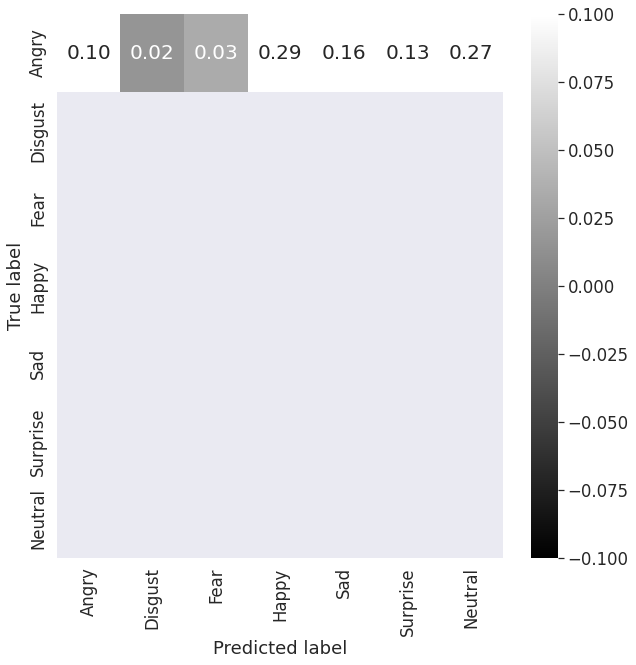

In [21]:
# Create emotions map:
emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# Predict using trained model:
y_pred = Claudia.predict(x_test)
y_pred = np.asarray([np.argmax(e) for e in y_pred])
y_true = np.asarray([np.argmax(e) for e in y_test])

# Compute confusion matrix:
cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix:
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                 cmap='gray', yticklabels=emotion_labels,
                 xticklabels=emotion_labels, vmin=0,
                 vmax=np.max(cm_normalised), fmt=".2f",
                 annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')